## Introduction

I have chosen to do this assignment with my personal Toggl Track archive. Toggl is a time-tracking application that records time entries whenever a timer is manually started and stopped. Each entry corresponds to a logged work session and can be labeled with projects, task descriptions, and tags.

I began using Toggl at around the start of my sophomore year (October 2024). At the time, my motivation was practical, I wanted to understand how much time I was actually spending on assignments and pre-class work in order to manage my workload more intentionally. Like most Minervans, I felt busy, but I didn’t have a quantitative understanding of where my time was going.

Very quickly, the Toggl became more than a temporary measurement device. I noticed that I worked more efficiently when the stopwatch was running. The act of tracking introduced a mild accountability mechanism, where I felt like if the timer was on, the time needed to “mean something.” In that sense, the data is not just a passive record of behavior, but partially shaped by the act of measurement itself. Turning on the timer became a ritual for “locking in,” and over time it has become second nature, especially when beginning focused work or tracking hours for contracting roles.

Each row in this dataset represents a discrete focus block — a period of intentional, uninterrupted work. When I leave my laptop, get distracted, or shift context, I pause the timer. Because of this, I believe the durations recorded are fairly representative of true focused work time rather than ambient laptop time. The dataset therefore approximates my ability to sustain attention across different projects, times of day, and motivational states.

Up to this point, I have only looked at daily and weekly summaries to estimate workload (and ability to focus). I have never modeled the data. This project is therefore my first attempt to treat my own time as something that can be analyzed, characterized, and potentially predicted. The central question motivating this assignment is “Can I predict how much time I will spend on a particular task at a particular time of day?” If possible, such a model could serve as a realistic proxy for expected focus capacity. Instead of assuming, out of sheer willpower, that a task “should” fit into a certain time block, I could use historical behavioral data to estimate what is actually likely.

### The Data

The dataset was exported directly from Toggl using the built-in export feature. It contains 1,340 recorded work sessions between October 1, 2024 and February 15, 2026. Each row represents one recorded time entry (a focus block).

The raw export includes the following fields:

- `Description` (string, free-text task label)
- `Billable` (binary, whether the session was marked as billable work)
- `Duration` (stored in HH:MM:SS format)
- `Member` and `Email` (string, account data)
- `Project` (string, primary grouping category — only one per time block)
- `Tags` (string(s), optional secondary labels — multiple possible per time block)
- `Start date` and `Start time` (in YYYY-MM-DD and HH:MM:SS format respectively)
- `Stop date` and `Stop time`  (in YYYY-MM-DD and HH:MM:SS format respectively)

Structurally, the dataset is event-based: each row captures the beginning and end of a single tracked session. Before modeling, I will need to convert duration from HH:MM:SS into a continuous numerical variable (probably total minutes). The start and stop timestamps will also need to be combined into a single datetime object to derive features like hour of day, weekday, or period of the year.

Because this dataset reflects how I personally organized my things on Toggl, some preprocessing requires me to fix my own inconsistencies. For example, I currently have a project titled “work” where I track time spent at jobs or internships. However, before creating that unified project, I stored work hours under individual project names such as “surfwisely.” From a modeling perspective, these should be consolidated under the single “work” category to prevent artificial fragmentation of the label space.

There are also fields that are present in the export but not meaningfully used by me as a user. Variables such as Billable, Member, Email, and Tags do not contain useful signal for this particular modeling goal (because I don’t use those features) and can reasonably be removed during preprocessing.

This dataset spans multiple semesters, jobs, shifts in academic intensity, and changes in routine. It only captures time I’d consider focused productivity which does not include class time, park-walk brainstorm sessions, or moments where I was “half working” (for example, doing pre-class work on the bus). In that sense, it isn’t and shouldn’t be treated as a record of total cognitive labor, but a record of deliberate locked-in focus.

In [42]:
'''LOADING DATA INTO PYTHON'''

import pandas as pd

# Load data into pandas
csv_path = 'TogglTrack_Report_Detailed_report_(from_10_01_2024_to_02_15_2026).csv'
df = pd.read_csv(csv_path)

# Replace '-' in certain columns to be null
for col in ['Description', 'Project', 'Tags']:
    if col in df.columns:
        df[col] = df[col].replace('-', pd.NA)


Rows (raw): 1340
Average session length: 46.44 minutes
Median session length: 37.69 minutes
Duration skewness: 5.75
99th percentile: 162.44 minutes


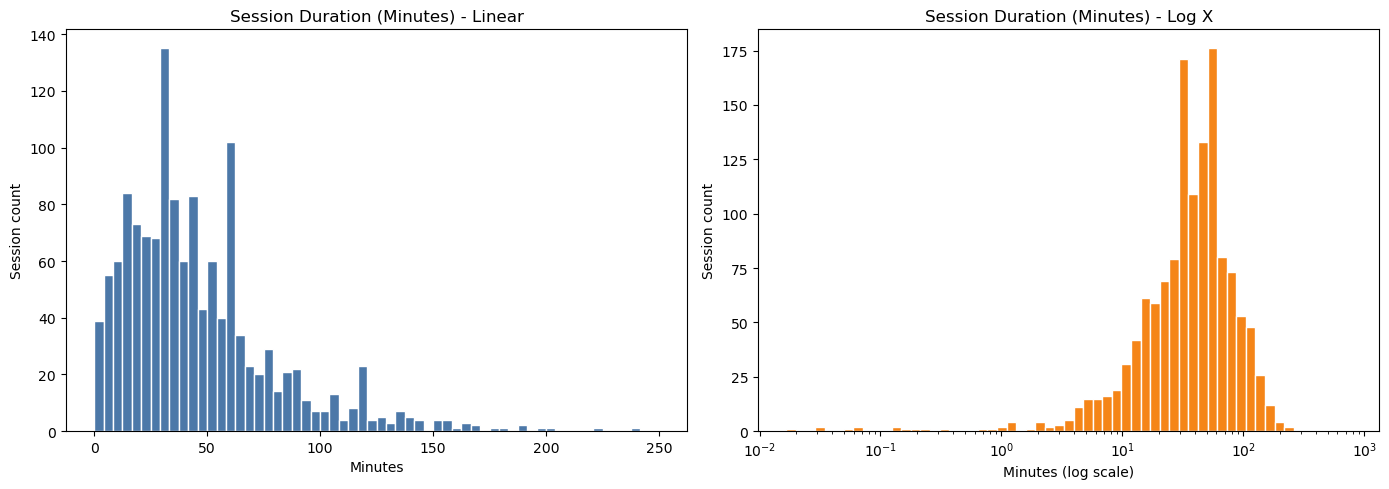

In [43]:
'''INITIAL SUMMARY STATS OF DATA'''

import numpy as np
import matplotlib.pyplot as plt

# Creates a new column in the dataframe converting the HH:MM:SS duration data into seconds
df['duration_seconds'] = pd.to_timedelta(df['Duration'], errors='coerce').dt.total_seconds()

# Basic stats
raw_count = len(df)
mean_min = df['duration_seconds'].mean() / 60       # Converts the duration (in seconds) to minutes
median_min = df['duration_seconds'].median() / 60
skewness = df['duration_seconds'].skew()
p99_min = df['duration_seconds'].quantile(0.99) / 60

print(f'Rows (raw): {raw_count}')
print(f'Average session length: {mean_min:.2f} minutes')
print(f'Median session length: {median_min:.2f} minutes')
print(f'Duration skewness: {skewness:.2f}')
print(f'99th percentile: {p99_min:.2f} minutes')

# Skew visualizations
dur_min = df['duration_seconds'] / 60 # duration in minutes
positive = dur_min[dur_min > 0]

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Linear histogram
axes[0].hist(positive, bins=60, range=(0,250), color='#4C78A8', edgecolor='white')
axes[0].set_title('Session Duration (Minutes) - Linear')
axes[0].set_xlabel('Minutes')
axes[0].set_ylabel('Session count')

# Log-scale x-axis histogram
log_bins = np.logspace(np.log10(positive.min()), np.log10(positive.max()), 60)
axes[1].hist(positive, bins=log_bins, color='#F58518', edgecolor='white')
axes[1].set_xscale('log')
axes[1].set_title('Session Duration (Minutes) - Log X')
axes[1].set_xlabel('Minutes (log scale)')
axes[1].set_ylabel('Session count')

plt.tight_layout()
plt.show()



I decided to first understand what my focus behavior actually looks like before data cleaning as I thought it would help me decide how I should approach pre-processing and generally building my model.

From the histogram on the linear scale, we can see that my focus time is pretty right-skewed. This means most of my sessions cluster under an hour, but there’s a long tail of much longer focus blocks. The 99th percentile is 162.44 minutes — which honestly I’m pretty surprised by — so most sessions are moderate in length but there are a few really long sessions that create that long tail.

A skewed distribution is difficult to model so I also plotted the data on a log scale. After plotting the distribution became much more balanced and interpretable, so a transformation may be necessary for modeling.

## Data Cleaning, Pre-Processing, Feature Engineering, and Exploratory Data Analysis

Before modeling, I need to clean and standardize this dataset so categories and durations are consistent.

Cleaning and pre-processing decisions:
- Standardize placeholder values: convert `-` to missing (`NA`) for text columns.
- Consolidate project naming: map `surfwisely` into the broader `work` project.
- Consolidate coursework labels: merge CS project variants into `CS pcw` and BZ project variants into `BZ pcw`.
- Reassign administrative sessions: if description contains `admin` (case-insensitive), set project to `admin`.
- For missing projects: if session duration is over 1 minute, relabel as `admin`; if 1 minute or under, drop as likely accidental.
- Parse duration to numeric minutes and parse start/stop timestamps into datetime.
- Remove rows with invalid or non-positive durations.
- Drop columns that are not useful for this modeling goal (`Billable`, `Member`, `Email`, `Tags`, raw stop fields).

Feature engineering decisions:
- `duration_minutes` and `log_duration_minutes` for modeling skewed session lengths.
- Calendar/time features from start datetime: `hour`, `weekday`, `is_weekend`, `month`.

I'm going to do more exploratory data analysis after the data is cleaned, like visualizing the distribution of duration and session counts by project and computing descriptive stats for the time block durations with the hope that this will help me identify whether certain projects consistently produce longer sessions, whether there are meaningful differences across weekdays, and whether the log transformation meaningfully stabilizes the variance before modeling.




In [44]:
''' CLEANING + PREPROCESSING + FEATURE ENGINEERING '''

csv_path = 'TogglTrack_Report_Detailed_report_(from_10_01_2024_to_02_15_2026).csv'
df_raw = pd.read_csv(csv_path)
df_clean = df_raw.copy()  # Create a new dataframe for cleaned data

# 1) Replace '-' with missing values
for col in ['Description', 'Project', 'Tags']:
    if col in df_clean.columns:
        df_clean[col] = df_clean[col].replace('-', pd.NA)

# 2) Project grouping consolidation
# Group "surfwisely" project into "work" project
df_clean.loc[df_clean['Project'] == 'surfwisely', 'Project'] = 'work'

# Any description containing 'admin' should belong to admin project
if 'Description' in df_clean.columns:
    admin_mask = df_clean['Description'].astype('string').str.contains('admin', case=False, na=False)
    df_clean.loc[admin_mask, 'Project'] = 'admin'

# 3) Parse durations and timestamps
# Duration is stored as HH:MM:SS in the csv file
df_clean['duration_seconds'] = pd.to_timedelta(df_clean['Duration'], errors='coerce').dt.total_seconds()
df_clean['duration_minutes'] = df_clean['duration_seconds'] / 60

# Remove rows with invalid or non-positive duration
rows_before_duration_filter = len(df_clean)
df_clean = df_clean[df_clean['duration_minutes'].notna() & (df_clean['duration_minutes'] > 0)].copy()

# Missing project rule:
# - If duration > 1 minute, recode to admin
# - If duration <= 1 minute, drop (likely accidental entries)
missing_project_mask = df_clean['Project'].isna()
accidental_missing_mask = missing_project_mask & (df_clean['duration_minutes'] <= 1)
recode_admin_mask = missing_project_mask & (df_clean['duration_minutes'] > 1)

df_clean = df_clean.loc[~accidental_missing_mask].copy()
df_clean.loc[recode_admin_mask, 'Project'] = 'admin'

# Concatenate date and time into one string and convert to datetime
df_clean['start_datetime'] = pd.to_datetime(
    df_clean['Start date'].astype('string') + ' ' + df_clean['Start time'].astype('string'),
    errors='coerce'
)
df_clean['stop_datetime'] = pd.to_datetime(
    df_clean['Stop date'].astype('string') + ' ' + df_clean['Stop time'].astype('string'),
    errors='coerce'
)

# 4) Feature engineering for downstream modeling and EDA
df_clean['hour'] = df_clean['start_datetime'].dt.hour   # Extracts starting hour (i.e. 14 in 14:30:00 datetime object)
df_clean['weekday'] = df_clean['start_datetime'].dt.day_name()  # Converts datetime into weekday names (i.e. 'Monday', 'Tuesday') for each time entry
df_clean['is_weekend'] = df_clean['weekday'].isin(['Saturday', 'Sunday']).astype(int)   # Categorizes whether each entry is on a weekend
df_clean['month'] = df_clean['start_datetime'].dt.month # Returns the month as an integer
df_clean['log_duration_minutes'] = np.log1p(df_clean['duration_minutes'])   # Computes log(1 + x) as a log transformation so zeros can be handled

# Time-of-day bucket for duration comparisons
# Morning: 5-11, Afternoon: 12-17, Night: 18-4
df_clean['time_of_day'] = np.select(
    [
        df_clean['hour'].between(5, 11, inclusive='both'),
        df_clean['hour'].between(12, 17, inclusive='both')
    ],
    ['morning', 'afternoon'],
    default='night'
)

# 5) Remove non-informative columns
drop_cols = ['Billable', 'Member', 'Email', 'Tags', 'Stop date', 'Stop time']
model_df = df_clean.drop(columns=[c for c in drop_cols if c in df_clean.columns]).copy()

weekday_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
time_of_day_order = ['morning', 'afternoon', 'night']

print(f'Rows before duration filter: {rows_before_duration_filter}')
print(f'Rows after duration filter and missing-project rule: {len(model_df)}')

print('Sample of cleaned data:')
print(model_df[['Description', 'Project', 'duration_minutes', 'hour', 'weekday', 'time_of_day']].head(5))

print()
print('Duration descriptive statistics (minutes):')
print(model_df['duration_minutes'].describe(percentiles=[0.25, 0.5, 0.75, 0.9, 0.95, 0.99]))
print(f"Skewness (raw minutes): {model_df['duration_minutes'].skew():.2f}")
print(f"Skewness (log minutes): {model_df['log_duration_minutes'].skew():.2f}")

print()
print('Average session duration (minutes) by weekday:')
avg_by_weekday = model_df.groupby('weekday')['duration_minutes'].mean().reindex(weekday_order)
print(avg_by_weekday.round(2))

print()
print('Average session duration (minutes) by time of day:')
avg_by_time_of_day = model_df.groupby('time_of_day')['duration_minutes'].mean().reindex(time_of_day_order)
print(avg_by_time_of_day.round(2))

print()
print('Top 10 projects by session count:')
print(model_df['Project'].value_counts().head(10))






Rows before duration filter: 1340
Rows after duration filter and missing-project rule: 1335
Sample of cleaned data:
  Description Project  duration_minutes  hour weekday time_of_day
0        work    work         10.300000    14  Sunday   afternoon
1       admin   admin         24.433333    13  Sunday   afternoon
2        <NA>     AIC         25.216667    22  Friday       night
3       admin   admin         15.233333    22  Friday       night
4        work    work         69.100000    13  Friday   afternoon

Duration descriptive statistics (minutes):
count    1335.000000
mean       46.611948
std        39.417991
min         0.016667
25%        22.050000
50%        37.766667
75%        60.000000
90%        90.000000
95%       120.000000
99%       162.483333
max       780.000000
Name: duration_minutes, dtype: float64
Skewness (raw minutes): 5.77
Skewness (log minutes): -0.91

Average session duration (minutes) by weekday:
weekday
Monday       43.39
Tuesday      43.60
Wednesday    45.65
Th

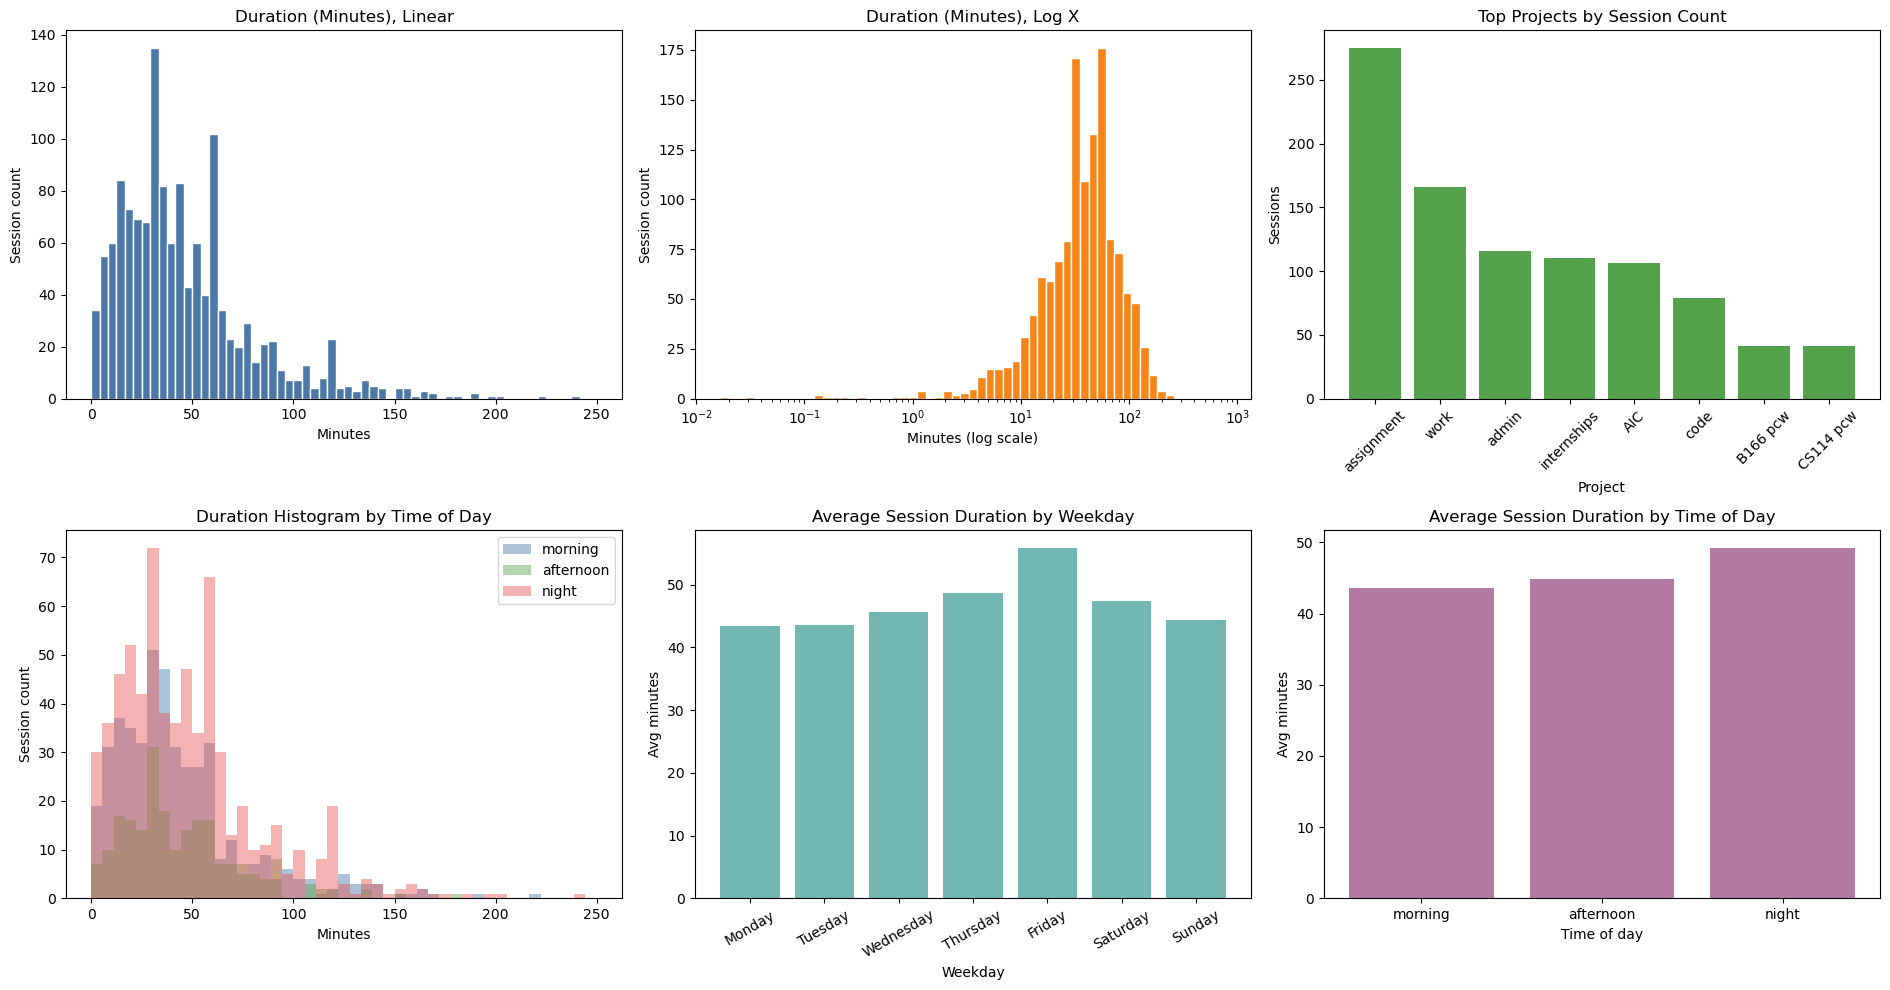

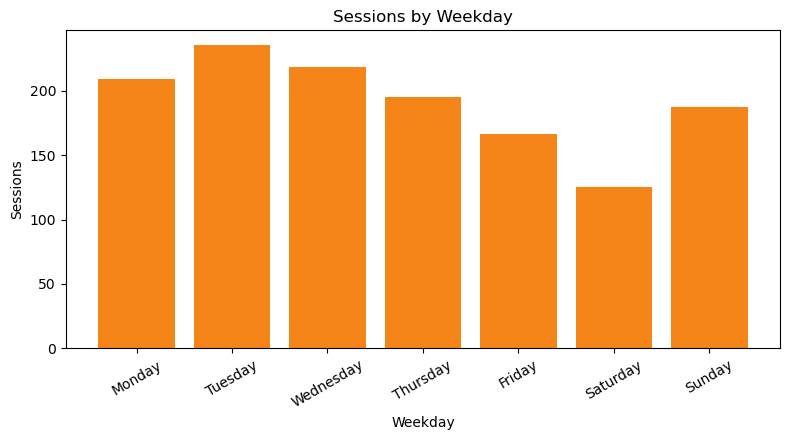

In [45]:
''' EXPLORATORY DATA ANALYSIS VISUALIZATIONS '''

weekday_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
time_of_day_order = ['morning', 'afternoon', 'night']

fig, axes = plt.subplots(2, 3, figsize=(19, 10))

# 1) Duration distribution (linear, capped)
axes[0, 0].hist(model_df['duration_minutes'], bins=60, range=(0, 250), color='#4C78A8', edgecolor='white')
axes[0, 0].set_title('Duration (Minutes), Linear')
axes[0, 0].set_xlabel('Minutes')
axes[0, 0].set_ylabel('Session count')

# 2) Duration distribution (log-x)
positive_minutes = model_df.loc[model_df['duration_minutes'] > 0, 'duration_minutes']
log_bins = np.logspace(np.log10(positive_minutes.min()), np.log10(positive_minutes.max()), 60)
axes[0, 1].hist(positive_minutes, bins=log_bins, color='#F58518', edgecolor='white')
axes[0, 1].set_xscale('log')
axes[0, 1].set_title('Duration (Minutes), Log X')
axes[0, 1].set_xlabel('Minutes (log scale)')
axes[0, 1].set_ylabel('Session count')

# 3) Top projects by session count
project_counts = model_df['Project'].value_counts().head(8)
axes[0, 2].bar(project_counts.index, project_counts.values, color='#54A24B')
axes[0, 2].set_title('Top Projects by Session Count')
axes[0, 2].set_xlabel('Project')
axes[0, 2].set_ylabel('Sessions')
axes[0, 2].tick_params(axis='x', rotation=45)

# 4) Histogram split by time of day
for label, color in [('morning', '#4C78A8'), ('afternoon', '#54A24B'), ('night', '#E45756')]:
    subset = model_df.loc[model_df['time_of_day'] == label, 'duration_minutes']
    axes[1, 0].hist(subset, bins=45, range=(0, 250), alpha=0.45, label=label, color=color)
axes[1, 0].set_title('Duration Histogram by Time of Day')
axes[1, 0].set_xlabel('Minutes')
axes[1, 0].set_ylabel('Session count')
axes[1, 0].legend()

# 5) Average session duration by weekday
avg_by_weekday = model_df.groupby('weekday')['duration_minutes'].mean().reindex(weekday_order)
axes[1, 1].bar(avg_by_weekday.index, avg_by_weekday.values, color='#72B7B2')
axes[1, 1].set_title('Average Session Duration by Weekday')
axes[1, 1].set_xlabel('Weekday')
axes[1, 1].set_ylabel('Avg minutes')
axes[1, 1].tick_params(axis='x', rotation=30)

# 6) Average session duration by time of day
avg_by_time_of_day = model_df.groupby('time_of_day')['duration_minutes'].mean().reindex(time_of_day_order)
axes[1, 2].bar(avg_by_time_of_day.index, avg_by_time_of_day.values, color='#B279A2')
axes[1, 2].set_title('Average Session Duration by Time of Day')
axes[1, 2].set_xlabel('Time of day')
axes[1, 2].set_ylabel('Avg minutes')

plt.tight_layout()
plt.show()

# Restored: sessions by weekday (count view)
weekday_counts = model_df['weekday'].value_counts().reindex(weekday_order)
plt.figure(figsize=(8, 4.5))
plt.bar(weekday_counts.index, weekday_counts.values, color='#F58518')
plt.title('Sessions by Weekday')
plt.xlabel('Weekday')
plt.ylabel('Sessions')
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()



Looking at the cleaned visualizations, a few patterns stand out immediately.

First, there seems to be a clear structure in the number of sessions per weekday. Tuesday and Wednesday appear to have the highest session counts, while Saturday is noticeably lower. Thinking abou tit, this might make sense because I don’t have any classes on Fridays or Saturdays, whereas I tend to have more things going on midweek, so this could be representative of the disruptions I have (classes, meetings, etc.) where I have to stop a work block and am generally more interrupted. 

There is also a slight but noticeable difference in average session duration by weekday. Friday appears to have the highest average duration, while Monday and Tuesday are slightly shorter. The differences aren’t extreme, but they suggest that not only does the number of sessions vary across the week, but the quality or length of focus blocks might as well. This could imply behavioral differences like Fridays allowing for longer uninterrupted work.

The Top Projects by Session Count visualization also reveals something important — but also slightly misleading. “Assignment” appears dominant, but that category aggregates work across all classes in the last year and a half. Meanwhile, the pre-class work time is broken out individually per class. This makes the comparison somewhat unfair: “assignment” is broad and pooled, while other categories are granular and fragmented. From a modeling perspective, this inconsistency could introduce bias and artificial imbalance in the feature space. It may therefore make sense to standardize project groupings — for example, consolidating all business pre-class work into one category and all CS pre-class work into another. This would create a more conceptually fair comparison across projects and would also likely improve generalization of the model to other classes I may take in the future. It also works out nicely, as I have taken the same amount of business classes as I have taken CS classes.

Top 10 projects after re-grouping:
Project
assignment       275
BZ pcw           185
CS pcw           174
work             166
admin            116
internships      110
AIC              106
code              79
180DC             40
skill builder     27
Name: count, dtype: int64


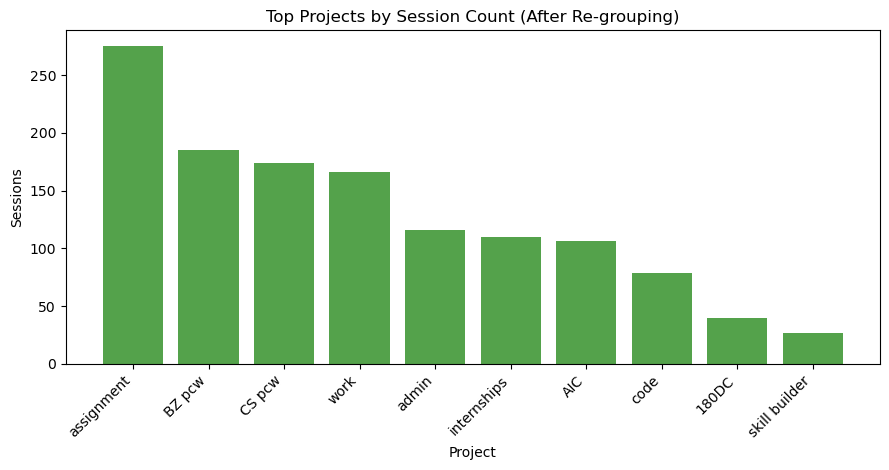

In [46]:
''' REGROUPING PROJECT TYPES'''

# Re-group pre-class work projects into broader categories
# This updates the SAME dataframe used by later cells (model_df), so the notebook remains consistent.
cs_pcw_projects = ['CS111 pcw', 'CS114 pcw', 'CS113 pcw', 'CS110 pcw', 'CS152 pcw', 'CS156 pcw']
bz_pcw_projects = ['B110 pcw', 'B111 pcw', 'B112 pcw', 'B113 pcw', 'B166 pcw', 'B156 pcw']

model_df.loc[model_df['Project'].isin(cs_pcw_projects), 'Project'] = 'CS pcw'
model_df.loc[model_df['Project'].isin(bz_pcw_projects), 'Project'] = 'BZ pcw'

print('Top 10 projects after re-grouping:')
print(model_df['Project'].value_counts().head(10))

# Re-graph top projects by session count using updated model_df
project_counts = model_df['Project'].value_counts().head(10)
plt.figure(figsize=(9, 4.8))
plt.bar(project_counts.index, project_counts.values, color='#54A24B')
plt.title('Top Projects by Session Count (After Re-grouping)')
plt.xlabel('Project')
plt.ylabel('Sessions')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()



## Modelling Plan

This problem is best framed as a **regression** task because the target variable (`duration_minutes`) is continuous. I am trying to predict how long a future focus session will last, not assign it to a category.

At the start of a session, certain information is already known: the project being working on, the weekday, the hour of day, the month, whether it is a weekend, and broader time-of-day groupings. The model should only use features that are available at the moment the session begins. If, instead, a classification were to be done, that would require binning duration into arbitrary buckets like short, medium, or long, which would discard useful information. Clustering could reveal behavioral patterns, but it wouldn’t be able to forecast the session length.

Upon researching regression models I could use for this task, I came across tree-based regressors. Tree-based regressors work by recursively partitioning the feature space into smaller and smaller regions using a sequence of “if-then” splits. In my model, this would mean the tree might split first on something like time of day (morning vs night), then within that split on project, then maybe on weekday or whether it’s a weekend, until each final group contains sessions that tend to have similar lengths. At each split, the model chooses the feature (and threshold) that best reduces prediction error. In regression, this typically means choosing splits that make the target values inside each region as similar as possible (i.e., minimizing variance / mean squared error within each leaf). Conceptually, it’s learning simple rules like: *“If it’s Friday night and I’m working on AIC, sessions tend to run longer.”*

Upon further investigation into tree-based regressors, I found that a single Decision Tree regressor, a Gradient Boosted Tree model (e.g., XGBoost/GradientBoostingRegressor), and a Random Forest regressor could all work for my dataset:

- A **Decision Tree Regressor** is the simplest version. It keeps splitting until it can make pretty specific predictions. It’s intuitive and can capture non-linear patterns, but it overfits quickly, learning patterns that may only be true for some period of time.
- **Gradient Boosted Trees** (like XGBoost) build many small trees sequentially, where each new tree tries to correct the errors of the previous ones. These models can be very accurate, but they usually require more careful tuning.
- A **Random Forest Regressor** trains many decision trees in parallel on bootstrapped samples of the training data and then averages their predictions. This typically makes it **more stable and less sensitive** to quirks in the training set than a single tree, while still capturing interactions like project × weekday × time-of-day.

In [47]:
''' SECTION 4: DATASPLITS '''

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Keep model metrics in one place for comparison across models for later.
if 'model_scores' not in globals():
    model_scores = []

# Build modeling table from dataframe
modeling_df = model_df.copy()
modeling_df = modeling_df.dropna(subset=['start_datetime', 'duration_minutes', 'log_duration_minutes'])
modeling_df = modeling_df.sort_values('start_datetime').reset_index(drop=True)

feature_cols = ['Project', 'weekday', 'hour', 'month', 'is_weekend', 'time_of_day']
X = modeling_df[feature_cols]
y = modeling_df['log_duration_minutes']

split_idx = int(len(modeling_df) * 0.8)
X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]

categorical_features = ['Project', 'weekday', 'time_of_day']
numeric_features = ['hour', 'month', 'is_weekend']

preprocess = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features),
        ('num', 'passthrough', numeric_features),
    ]
)


## Training Models

In [48]:
''' SECTION 5A: DECISION TREE REGRESSOR '''

from sklearn.tree import DecisionTreeRegressor

dt_model = DecisionTreeRegressor(
    random_state=42,
    max_depth=10,
    min_samples_leaf=5,
)

dt_pipeline = Pipeline([
    ('preprocess', preprocess),
    ('model', dt_model),
])

dt_pipeline.fit(X_train, y_train)
y_pred_log = dt_pipeline.predict(X_test)

# Convert back to minutes for interpretable metrics.
y_test_min = np.expm1(y_test)
y_pred_min = np.expm1(y_pred_log)

mae = mean_absolute_error(y_test_min, y_pred_min)
rmse = np.sqrt(mean_squared_error(y_test_min, y_pred_min))
r2 = r2_score(y_test_min, y_pred_min)

model_scores = [m for m in model_scores if m['model'] != 'DecisionTreeRegressor']
model_scores.append({'model': 'DecisionTreeRegressor', 'MAE': mae, 'RMSE': rmse, 'R2': r2})

print('Decision Tree performance (minutes scale):')
print(f'MAE:  {mae:.2f} minutes')
print(f'RMSE: {rmse:.2f} minutes')
print(f'R^2:  {r2:.3f}')
print(pd.DataFrame(model_scores).sort_values('RMSE').to_string(index=False))


Decision Tree performance (minutes scale):
MAE:  27.51 minutes
RMSE: 35.98 minutes
R^2:  -0.352
                model       MAE      RMSE        R2
RandomForestRegressor 23.388257 31.697544 -0.049894
DecisionTreeRegressor 27.511202 35.975704 -0.352424
         XGBRegressor 27.237261 40.370128 -0.702999


In [49]:
''' SECTION 5B: XGBOOST REGRESSOR '''

from xgboost import XGBRegressor

if 'model_scores' not in globals():
    model_scores = []

# Build modeling table from datagrame
modeling_df = model_df.copy()
modeling_df = modeling_df.dropna(subset=['start_datetime', 'duration_minutes', 'log_duration_minutes'])
modeling_df = modeling_df.sort_values('start_datetime').reset_index(drop=True)

feature_cols = ['Project', 'weekday', 'hour', 'month', 'is_weekend', 'time_of_day']
X = modeling_df[feature_cols]
y = modeling_df['log_duration_minutes']

split_idx = int(len(modeling_df) * 0.8)
X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]

categorical_features = ['Project', 'weekday', 'time_of_day']
numeric_features = ['hour', 'month', 'is_weekend']

preprocess = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features),
        ('num', 'passthrough', numeric_features),
    ]
)

xgb_model = XGBRegressor(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=5,
    subsample=0.9,
    colsample_bytree=0.9,
    objective='reg:squarederror',
    random_state=42,
)

xgb_pipeline = Pipeline([
    ('preprocess', preprocess),
    ('model', xgb_model),
])

xgb_pipeline.fit(X_train, y_train)
y_pred_log = xgb_pipeline.predict(X_test)

y_test_min = np.expm1(y_test)
y_pred_min = np.expm1(y_pred_log)

mae = mean_absolute_error(y_test_min, y_pred_min)
rmse = np.sqrt(mean_squared_error(y_test_min, y_pred_min))
r2 = r2_score(y_test_min, y_pred_min)

model_scores = [m for m in model_scores if m['model'] != 'XGBRegressor']
model_scores.append({'model': 'XGBRegressor', 'MAE': mae, 'RMSE': rmse, 'R2': r2})

print('XGBoost performance (minutes scale):')
print(f'MAE:  {mae:.2f} minutes')
print(f'RMSE: {rmse:.2f} minutes')
print(f'R^2:  {r2:.3f}')
print(pd.DataFrame(model_scores).sort_values('RMSE').to_string(index=False))



XGBoost performance (minutes scale):
MAE:  27.24 minutes
RMSE: 40.37 minutes
R^2:  -0.703
                model       MAE      RMSE        R2
RandomForestRegressor 23.388257 31.697544 -0.049894
DecisionTreeRegressor 27.511202 35.975704 -0.352424
         XGBRegressor 27.237261 40.370128 -0.702999


In [50]:
''' SECTION 4C: RANDOM FOREST REGRESSOR '''
from sklearn.ensemble import RandomForestRegressor

rf_model = RandomForestRegressor(
    n_estimators=400,
    random_state=42,
    min_samples_leaf=2,
    n_jobs=-1,
)

rf_pipeline = Pipeline([
    ('preprocess', preprocess),
    ('model', rf_model),
])

rf_pipeline.fit(X_train, y_train)
y_pred_log = rf_pipeline.predict(X_test)

y_test_min = np.expm1(y_test)
y_pred_min = np.expm1(y_pred_log)

mae = mean_absolute_error(y_test_min, y_pred_min)
rmse = np.sqrt(mean_squared_error(y_test_min, y_pred_min))
r2 = r2_score(y_test_min, y_pred_min)

model_scores = [m for m in model_scores if m['model'] != 'RandomForestRegressor']
model_scores.append({'model': 'RandomForestRegressor', 'MAE': mae, 'RMSE': rmse, 'R2': r2})

print('Random Forest performance (minutes scale):')
print(f'MAE:  {mae:.2f} minutes')
print(f'RMSE: {rmse:.2f} minutes')
print(f'R^2:  {r2:.3f}')

score_df = pd.DataFrame(model_scores).sort_values('RMSE').reset_index(drop=True)
print()
print('Model comparison:')
print(score_df.to_string(index=False))



Random Forest performance (minutes scale):
MAE:  23.39 minutes
RMSE: 31.70 minutes
R^2:  -0.050

Model comparison:
                model       MAE      RMSE        R2
RandomForestRegressor 23.388257 31.697544 -0.049894
DecisionTreeRegressor 27.511202 35.975704 -0.352424
         XGBRegressor 27.237261 40.370128 -0.702999


In [51]:
baseline_pred = np.expm1(y_train).mean()

baseline_preds = np.full_like(y_test_min, baseline_pred)

baseline_rmse = np.sqrt(mean_squared_error(y_test_min, baseline_preds))
baseline_r2 = r2_score(y_test_min, baseline_preds)

print("Baseline RMSE:", baseline_rmse)
print("Baseline R2:", baseline_r2)

Baseline RMSE: 31.106841014748454
Baseline R2: -0.011127743672151302


Comparing the three models, the Random Forest Regressor has the lowest MAE and RMSE. In context, that means its predictions are off by about 23 minutes on average, compared to about 28 minutes for the Decision Tree and 27 minutes for XGBoost. RMSE tells a similar story: Random Forest has the smallest typical error once larger mistakes are penalized more heavily.

That said, all three models and the baseline have a negative R^2 on the test set. A negative R^2 means that, on this held-out time period, the models are performing worse than a simple baseline that always predicts the average session length. So while Random Forest is “best” of the three, these results suggest that the current feature set (project + calendar features) is not yet capturing enough signal to reliably forecast session duration — or that the data is noisy/non-stationary enough that the model struggles to generalize across time.

To address the negative R^2, my next step is to add state-based features that better reflect what my focus capacity looks like at the moment a session starts. Calendar features (weekday/hour/month) capture routine, but they don’t capture my current “work state.” I will engineer variables such as time since the previous session, number of sessions so far today, and total minutes tracked so far today, simple rolling summaries (e.g., recent average or median session length over the past week), along with introducing a new 'is_summer' variable. These features should give the model more direct signal about whether I’m warming up, fatigued, already deep in a workday, or returning after a long break — all of which plausibly influence session duration and could help push performance above the baseline (and make R^2 positive). At the same time, the current results suggest the model may be overfitting to quirks in the training period and failing to generalize forward in time, so I will also tighten regularization by increasing parameters like `min_samples_leaf` and constraining `max_depth` to make the Random Forest less sensitive to rare patterns and outliers.

I was a little surprised that XGBoost performed worse than the single Decision Tree. After looking into it more, I realized that boosted tree models like XGBoost are powerful, but they’re also more sensitive to hyperparameters and can overfit (or underfit) pretty easily if they aren’t tuned carefully—especially on a noisy, single-person behavioral dataset like mine. In contrast, Random Forests tend to be a more stable “first choice” baseline in settings like this because they average predictions across many decorrelated trees, which helps smooth out randomness and reduce the impact of any one quirky pattern in the training period. For that reason, I’m going to proceed with the Random Forest Regressor as my main model for the next iteration.


In [62]:
''' SECTION 5D: RANDOM FOREST WITH SESSION-CONTEXT FEATURES '''

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Build from current dataframe state (after all prior cleaning/re-grouping cells).
rf_df = model_df.copy()
rf_df = rf_df.dropna(subset=['start_datetime', 'stop_datetime', 'duration_minutes', 'log_duration_minutes'])
rf_df = rf_df.sort_values('start_datetime').reset_index(drop=True)

# Clip extreme outliers: keep sessions up to 2 hours (120 minutes).
rows_before_outlier_clip = len(rf_df)
rf_df = rf_df[rf_df['duration_minutes'] <= 120].copy()
rows_after_outlier_clip = len(rf_df)

# 1) Time since previous session (minutes) based on previous session end -> current start.
rf_df['minutes_since_prev_session'] = (
    rf_df['start_datetime'] - rf_df['stop_datetime'].shift(1)
).dt.total_seconds() / 60
rf_df['minutes_since_prev_session'] = rf_df['minutes_since_prev_session'].clip(lower=0)

# 2) Number of sessions completed so far today (exclude current row).
rf_df['session_date'] = rf_df['start_datetime'].dt.date
rf_df['sessions_so_far_today'] = rf_df.groupby('session_date').cumcount()

# 3) Total minutes tracked so far today (exclude current session).
running_today = rf_df.groupby('session_date')['duration_minutes'].cumsum()
rf_df['minutes_so_far_today'] = running_today - rf_df['duration_minutes']

# 4) Rolling summaries over the prior 7 days (exclude current session to avoid leakage).
rf_df = rf_df.set_index('start_datetime')
rf_df['recent_avg_minutes_7d'] = rf_df['duration_minutes'].shift(1).rolling('7D', min_periods=1).mean()
rf_df['recent_median_minutes_7d'] = rf_df['duration_minutes'].shift(1).rolling('7D', min_periods=1).median()
rf_df = rf_df.reset_index()

# Fill early-session NaNs with global central values.
rf_df['minutes_since_prev_session'] = rf_df['minutes_since_prev_session'].fillna(rf_df['minutes_since_prev_session'].median())
rf_df['recent_avg_minutes_7d'] = rf_df['recent_avg_minutes_7d'].fillna(rf_df['duration_minutes'].mean())
rf_df['recent_median_minutes_7d'] = rf_df['recent_median_minutes_7d'].fillna(rf_df['duration_minutes'].median())

# Features: baseline + new session-context variables.
feature_cols = [
    'Project',
    'weekday',
    'time_of_day',
    'hour',
    'month',
    'is_weekend',
    'minutes_since_prev_session',
    'sessions_so_far_today',
    'minutes_so_far_today',
    'recent_avg_minutes_7d',
    'recent_median_minutes_7d',
]

X = rf_df[feature_cols]
y = rf_df['log_duration_minutes']

# Chronological split (80/20) to evaluate future-period performance.
split_idx = int(len(rf_df) * 0.8)
X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]

categorical_features = ['Project', 'weekday', 'time_of_day']
numeric_features = [
    'hour',
    'month',
    'is_weekend',
    'minutes_since_prev_session',
    'sessions_so_far_today',
    'minutes_so_far_today',
    'recent_avg_minutes_7d',
    'recent_median_minutes_7d',
]

preprocess = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features),
        ('num', 'passthrough', numeric_features),
    ]
)

# Tighter regularization vs baseline RF to reduce overfitting to rare patterns/outliers.
rf_model = RandomForestRegressor(
    n_estimators=600,
    max_depth=8,
    min_samples_split=20,
    min_samples_leaf=10,
    max_features='sqrt',
    random_state=42,
    n_jobs=-1,
)

rf_pipeline = Pipeline([
    ('preprocess', preprocess),
    ('model', rf_model),
])

rf_pipeline.fit(X_train, y_train)
y_pred_log = rf_pipeline.predict(X_test)

# Report metrics in minutes for interpretability.
y_test_min = np.expm1(y_test)
y_pred_min = np.expm1(y_pred_log)

mae = mean_absolute_error(y_test_min, y_pred_min)
rmse = np.sqrt(mean_squared_error(y_test_min, y_pred_min))
r2 = r2_score(y_test_min, y_pred_min)
abs_error = np.abs(y_pred_min - y_test_min)
pct_within_5 = (abs_error <= 5).mean() * 100
pct_within_10 = (abs_error <= 10).mean() * 100

print('Random Forest with session-context features (minutes scale):')
print(f'Rows before clipping >120 min: {rows_before_outlier_clip}')
print(f'Rows after clipping >120 min:  {rows_after_outlier_clip}')
print()
print(f'Train rows: {len(X_train)} | Test rows: {len(X_test)}')
print(f'MAE:  {mae:.2f} minutes')
print(f'RMSE: {rmse:.2f} minutes')
print(f'R^2:  {r2:.3f}')
print()
print(f'Within 5 minutes:  {pct_within_5:.1f}%')
print(f'Within 10 minutes: {pct_within_10:.1f}%')



Random Forest with session-context features (minutes scale):
Rows before clipping >120 min: 1335
Rows after clipping >120 min:  1282

Train rows: 1025 | Test rows: 257
MAE:  21.43 minutes
RMSE: 28.10 minutes
R^2:  -0.067

Within 5 minutes:  14.4%
Within 10 minutes: 28.8%


In [63]:
r2_log = r2_score(y_test, y_pred_log)
mae_log = mean_absolute_error(y_test, y_pred_log)
rmse_log = np.sqrt(mean_squared_error(y_test, y_pred_log))

print("Evaluation in LOG space:")
print(f"MAE (log):  {mae_log:.4f}")
print(f"RMSE (log): {rmse_log:.4f}")
print(f"R^2 (log):  {r2_log:.4f}")

Evaluation in LOG space:
MAE (log):  0.5911
RMSE (log): 0.7477
R^2 (log):  0.0399


In [ ]:
''' SECTION 5E: BASELINE AFTER CLIPPING '''

# Baseline: always predict the mean of TRAINING log-duration
baseline_pred_log = y_train.mean()

# Convert baseline predictions to minutes
baseline_pred_min = np.expm1(baseline_pred_log)

# Create array of baseline predictions (same size as test set)
baseline_preds_min = np.full_like(y_test_min, baseline_pred_min)

# Compute metrics
baseline_mae = mean_absolute_error(y_test_min, baseline_preds_min)
baseline_rmse = np.sqrt(mean_squared_error(y_test_min, baseline_preds_min))
baseline_r2 = r2_score(y_test_min, baseline_preds_min)

baseline_abs_error = np.abs(baseline_preds_min - y_test_min)
baseline_within_5 = (baseline_abs_error <= 5).mean() * 100
baseline_within_10 = (baseline_abs_error <= 10).mean() * 100

print('Baseline (Mean Predictor) AFTER Clipping >120 minutes:')
print(f'MAE:  {baseline_mae:.2f} minutes')
print(f'RMSE: {baseline_rmse:.2f} minutes')
print(f'R^2:  {baseline_r2:.3f}')
print(f'Within 5 minutes:  {baseline_within_5:.1f}%')
print(f'Within 10 minutes: {baseline_within_10:.1f}%')

Baseline (Mean Predictor) AFTER Clipping >120 minutes:
MAE:  21.72 minutes
RMSE: 28.91 minutes
R^2:  -0.128
Within 5 minutes:  19.1%
Within 10 minutes: 27.6%


Clearly, still not very good at all. Might as well just use the mean since R^2 is still negative. Going to try to diagnose the problem.

## Diagnosis
To diagnose the negative R^2 issue, I rewrote the modeling setup to predict duration_minutes directly (no log transform), and then systematically tested multiple models across multiple feature sets under the same evaluation protocol.

The code first cleans and standardizes the dataset for a fair comparison: it drops rows missing required timestamps/targets, sorts sessions chronologically, and applies the same outlier rule as before (remove sessions > 120 minutes) to avoid a few extreme sessions dominating the loss. It then engineers optional “context” signals that might plausibly affect duration, such as minutes since the previous session, how many sessions have occurred today, minutes accumulated so far today, and rolling 7‑day summaries (recent average/median of past sessions).

For modeling, everything is wrapped in a Pipeline with a ColumnTransformer so preprocessing is done correctly and without leakage:
- categorical columns (e.g., Project, weekday, time_of_day) are one-hot encoded (handle_unknown="ignore")
- numeric columns (e.g., hour, month, and optional context features) are imputed and standardized (important for linear models and neural nets)
To mimic a real forecasting setting, the split is chronological (first 80% train, last 20% test).



In [ ]:
''' LINEAR REGRESSION BASELINE -- TRYING A NON-TREE MODEL '''

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Use the same modeling setup as Section 5D for a fair comparison.
lin_df = model_df.copy()
lin_df = lin_df.dropna(subset=['start_datetime', 'stop_datetime', 'duration_minutes', 'log_duration_minutes'])
lin_df = lin_df.sort_values('start_datetime').reset_index(drop=True)

# Keep the same outlier policy: remove sessions longer than 2 hours.
lin_df = lin_df[lin_df['duration_minutes'] <= 120].copy()

# Session-context features
lin_df['minutes_since_prev_session'] = (
    lin_df['start_datetime'] - lin_df['stop_datetime'].shift(1)
).dt.total_seconds() / 60
lin_df['minutes_since_prev_session'] = lin_df['minutes_since_prev_session'].clip(lower=0)

lin_df['session_date'] = lin_df['start_datetime'].dt.date
lin_df['sessions_so_far_today'] = lin_df.groupby('session_date').cumcount()

running_today = lin_df.groupby('session_date')['duration_minutes'].cumsum()
lin_df['minutes_so_far_today'] = running_today - lin_df['duration_minutes']

lin_df = lin_df.set_index('start_datetime')
lin_df['recent_avg_minutes_7d'] = lin_df['duration_minutes'].shift(1).rolling('7D', min_periods=1).mean()
lin_df['recent_median_minutes_7d'] = lin_df['duration_minutes'].shift(1).rolling('7D', min_periods=1).median()
lin_df = lin_df.reset_index()

lin_df['minutes_since_prev_session'] = lin_df['minutes_since_prev_session'].fillna(lin_df['minutes_since_prev_session'].median())
lin_df['recent_avg_minutes_7d'] = lin_df['recent_avg_minutes_7d'].fillna(lin_df['duration_minutes'].mean())
lin_df['recent_median_minutes_7d'] = lin_df['recent_median_minutes_7d'].fillna(lin_df['duration_minutes'].median())

feature_cols = [
    'Project',
    'weekday',
    'time_of_day',
    'hour',
    'month',
    # 'is_weekend',
    # 'minutes_since_prev_session',
    # 'sessions_so_far_today',
    # 'minutes_so_far_today',
    # 'recent_avg_minutes_7d',
    # 'recent_median_minutes_7d',
]

X = lin_df[feature_cols]
y = lin_df['log_duration_minutes']

# Same chronological split for fair model comparison.
split_idx = int(len(lin_df) * 0.8)
X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]

categorical_features = ['Project', 'weekday', 'time_of_day']
numeric_features = [
    'hour',
    'month',
    # 'is_weekend',
   #  'minutes_since_prev_session',
    # 'sessions_so_far_today',
    # 'minutes_so_far_today',
    # 'recent_avg_minutes_7d',
    # 'recent_median_minutes_7d',
]

preprocess = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features),
        ('num', 'passthrough', numeric_features),
    ]
)

lin_model = LinearRegression()
lin_pipeline = Pipeline([
    ('preprocess', preprocess),
    ('model', lin_model),
])

lin_pipeline.fit(X_train, y_train)
y_pred_log = lin_pipeline.predict(X_test)

y_test_min = np.expm1(y_test)
y_pred_min = np.expm1(y_pred_log)

mae = mean_absolute_error(y_test_min, y_pred_min)
rmse = np.sqrt(mean_squared_error(y_test_min, y_pred_min))
r2 = r2_score(y_test_min, y_pred_min)
abs_error = np.abs(y_pred_min - y_test_min)
pct_within_5 = (abs_error <= 5).mean() * 100
pct_within_10 = (abs_error <= 10).mean() * 100

print('Linear Regression performance (minutes scale):')
print(f'Total rows used: {len(lin_df)}')
print(f'Train rows: {len(X_train)} | Test rows: {len(X_test)}')
print(f'MAE:  {mae:.2f} minutes')
print(f'RMSE: {rmse:.2f} minutes')
print(f'R^2:  {r2:.3f}')
print(f'Within 5 minutes:  {pct_within_5:.1f}%')
print(f'Within 10 minutes: {pct_within_10:.1f}%')



Linear Regression performance (minutes scale):
Total rows used: 1282
Train rows: 1025 | Test rows: 257
MAE:  21.15 minutes
RMSE: 27.84 minutes
R^2:  -0.047
Within 5 minutes:  16.7%
Within 10 minutes: 26.8%


In [72]:
import numpy as np
import pandas as pd

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer

from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


# ---------------------------
# 1) DATASET (no log targets)
# ---------------------------
lin_df = model_df.copy()

# Only require what's actually needed now
lin_df = lin_df.dropna(subset=["start_datetime", "stop_datetime", "duration_minutes"])
lin_df = lin_df.sort_values("start_datetime").reset_index(drop=True)

# Keep your same outlier policy
lin_df = lin_df[lin_df["duration_minutes"] <= 120].copy()

# Session-context features (optional — we'll toggle them in feature sets)
lin_df["minutes_since_prev_session"] = (
    lin_df["start_datetime"] - lin_df["stop_datetime"].shift(1)
).dt.total_seconds() / 60
lin_df["minutes_since_prev_session"] = lin_df["minutes_since_prev_session"].clip(lower=0)

lin_df["session_date"] = lin_df["start_datetime"].dt.date
lin_df["sessions_so_far_today"] = lin_df.groupby("session_date").cumcount()

running_today = lin_df.groupby("session_date")["duration_minutes"].cumsum()
lin_df["minutes_so_far_today"] = running_today - lin_df["duration_minutes"]

lin_df = lin_df.set_index("start_datetime")
lin_df["recent_avg_minutes_7d"] = lin_df["duration_minutes"].shift(1).rolling("7D", min_periods=1).mean()
lin_df["recent_median_minutes_7d"] = lin_df["duration_minutes"].shift(1).rolling("7D", min_periods=1).median()
lin_df = lin_df.reset_index()

# Target (minutes scale)
y = lin_df["duration_minutes"].astype(float)

# Chronological split (same logic as you had)
split_idx = int(len(lin_df) * 0.8)
train_idx = np.arange(0, split_idx)
test_idx  = np.arange(split_idx, len(lin_df))


# --------------------------------------
# 2) FEATURE SETS TO COMPARE (combinations)
# --------------------------------------
FEATURE_SETS = {
    "base_time_project": [
        "Project", "weekday", "time_of_day", "hour", "month"
    ],
    "base_plus_weekend": [
        "Project", "weekday", "time_of_day", "hour", "month", "is_weekend"
    ],
    "base_plus_spacing": [
        "Project", "weekday", "time_of_day", "hour", "month",
        "minutes_since_prev_session"
    ],
    "base_plus_today_context": [
        "Project", "weekday", "time_of_day", "hour", "month",
        "sessions_so_far_today", "minutes_so_far_today"
    ],
    "base_plus_7d_stats": [
        "Project", "weekday", "time_of_day", "hour", "month",
        "recent_avg_minutes_7d", "recent_median_minutes_7d"
    ],
    "all_context": [
        "Project", "weekday", "time_of_day", "hour", "month", "is_weekend",
        "minutes_since_prev_session", "sessions_so_far_today", "minutes_so_far_today",
        "recent_avg_minutes_7d", "recent_median_minutes_7d"
    ],
}

# Models to try (all benefit from scaling numerics)
MODELS = {
    "LinearRegression": LinearRegression(),
    "Ridge(1.0)": Ridge(alpha=1.0, random_state=0),
    "Lasso(0.01)": Lasso(alpha=0.01, random_state=0, max_iter=20000),
    "ElasticNet(0.01,0.5)": ElasticNet(alpha=0.01, l1_ratio=0.5, random_state=0, max_iter=20000),
}


# ------------------------------------------------
# 3) BUILD + EVALUATE PIPELINES (OHE + Scaling)
# ------------------------------------------------
def evaluate_one(feature_cols, model):
    X = lin_df[feature_cols].copy()

    # infer categorical vs numeric by dtype *and* known columns
    categorical_features = [c for c in feature_cols if X[c].dtype == "object"]
    numeric_features = [c for c in feature_cols if c not in categorical_features]

    # Preprocessing:
    # - Impute missing categoricals with most_frequent (safe for OHE)
    # - Impute missing numerics with median
    # - Scale numerics (important for linear / regularized models)
    preprocess = ColumnTransformer(
        transformers=[
            ("cat", Pipeline(steps=[
                ("imputer", SimpleImputer(strategy="most_frequent")),
                ("ohe", OneHotEncoder(handle_unknown="ignore")),
            ]), categorical_features),
            ("num", Pipeline(steps=[
                ("imputer", SimpleImputer(strategy="median")),
                ("scaler", StandardScaler()),
            ]), numeric_features),
        ],
        remainder="drop",
        verbose_feature_names_out=False
    )

    pipe = Pipeline([
        ("preprocess", preprocess),
        ("model", model),
    ])

    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)

    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)

    abs_error = np.abs(y_pred - y_test)
    pct_within_5 = (abs_error <= 5).mean() * 100
    pct_within_10 = (abs_error <= 10).mean() * 100

    return {
        "MAE": mae,
        "RMSE": rmse,
        "R2": r2,
        "Within_5_min_%": pct_within_5,
        "Within_10_min_%": pct_within_10,
        "Train_rows": len(X_train),
        "Test_rows": len(X_test),
    }


results = []
for fs_name, cols in FEATURE_SETS.items():
    # keep only columns that actually exist in your df (avoids crashes if e.g. is_weekend missing)
    cols_existing = [c for c in cols if c in lin_df.columns]

    for model_name, model in MODELS.items():
        metrics = evaluate_one(cols_existing, model)
        results.append({
            "feature_set": fs_name,
            "model": model_name,
            "n_features_raw": len(cols_existing),
            **metrics
        })

results_df = pd.DataFrame(results).sort_values(["MAE", "RMSE"], ascending=True)
display(results_df.head(20))

print("\nBest overall row:")
best = results_df.iloc[0]
print(best)


,feature_set,model,n_features_raw,MAE,RMSE,R2,Within_5_min_%,Within_10_min_%,Train_rows,Test_rows
10,base_plus_spacing,Lasso(0.01),6,21.171457,26.546198,0.048272,10.894942,25.680934,1025,257
8,base_plus_spacing,LinearRegression,6,21.175964,26.592993,0.044914,11.284047,25.680934,1025,257
9,base_plus_spacing,Ridge(1.0),6,21.176788,26.570896,0.046500,11.284047,26.070039,1025,257
11,base_plus_spacing,"ElasticNet(0.01,0.5)",6,21.189124,26.557228,0.047481,12.062257,25.291829,1025,257
2,base_time_project,Lasso(0.01),5,21.211972,26.596659,0.044650,10.505837,27.237354,1025,257
6,base_plus_weekend,Lasso(0.01),6,21.211972,26.596659,0.044650,10.505837,27.237354,1025,257
18,base_plus_7d_stats,Lasso(0.01),7,21.215416,26.564151,0.046984,12.062257,26.070039,1025,257
1,base_time_project,Ridge(1.0),5,21.217974,26.628158,0.042386,10.505837,27.237354,1025,257
5,base_plus_weekend,Ridge(1.0),6,21.217999,26.628130,0.042388,10.505837,27.237354,1025,257
17,base_plus_7d_stats,Ridge(1.0),7,21.220144,26.591878,0.044994,11.673152,26.070039,1025,257



Best overall row:
feature_set        base_plus_spacing
model                    Lasso(0.01)
n_features_raw                     6
MAE                        21.171457
RMSE                       26.546198
R2                          0.048272
Within_5_min_%             10.894942
Within_10_min_%            25.680934
Train_rows                      1025
Test_rows                        257
Name: 10, dtype: object


In [73]:
import numpy as np
import pandas as pd

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer

from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


# ---------------------------
# 1) DATASET (same as before)
# ---------------------------
mlp_df = model_df.copy()
mlp_df = mlp_df.dropna(subset=["start_datetime", "stop_datetime", "duration_minutes"])
mlp_df = mlp_df.sort_values("start_datetime").reset_index(drop=True)
mlp_df = mlp_df[mlp_df["duration_minutes"] <= 120].copy()

# Session-context features (optional; you can toggle in feature sets)
mlp_df["minutes_since_prev_session"] = (
    mlp_df["start_datetime"] - mlp_df["stop_datetime"].shift(1)
).dt.total_seconds() / 60
mlp_df["minutes_since_prev_session"] = mlp_df["minutes_since_prev_session"].clip(lower=0)

mlp_df["session_date"] = mlp_df["start_datetime"].dt.date
mlp_df["sessions_so_far_today"] = mlp_df.groupby("session_date").cumcount()

running_today = mlp_df.groupby("session_date")["duration_minutes"].cumsum()
mlp_df["minutes_so_far_today"] = running_today - mlp_df["duration_minutes"]

mlp_df = mlp_df.set_index("start_datetime")
mlp_df["recent_avg_minutes_7d"] = mlp_df["duration_minutes"].shift(1).rolling("7D", min_periods=1).mean()
mlp_df["recent_median_minutes_7d"] = mlp_df["duration_minutes"].shift(1).rolling("7D", min_periods=1).median()
mlp_df = mlp_df.reset_index()

y = mlp_df["duration_minutes"].astype(float)

# Chronological split
split_idx = int(len(mlp_df) * 0.8)
train_idx = np.arange(0, split_idx)
test_idx  = np.arange(split_idx, len(mlp_df))


# ---------------------------
# 2) FEATURE SETS (same idea)
# ---------------------------
FEATURE_SETS = {
    "base_time_project": [
        "Project", "weekday", "time_of_day", "hour", "month"
    ],
    "base_plus_weekend": [
        "Project", "weekday", "time_of_day", "hour", "month", "is_weekend"
    ],
    "base_plus_spacing": [
        "Project", "weekday", "time_of_day", "hour", "month",
        "minutes_since_prev_session"
    ],
    "base_plus_today_context": [
        "Project", "weekday", "time_of_day", "hour", "month",
        "sessions_so_far_today", "minutes_so_far_today"
    ],
    "base_plus_7d_stats": [
        "Project", "weekday", "time_of_day", "hour", "month",
        "recent_avg_minutes_7d", "recent_median_minutes_7d"
    ],
    "all_context": [
        "Project", "weekday", "time_of_day", "hour", "month", "is_weekend",
        "minutes_since_prev_session", "sessions_so_far_today", "minutes_so_far_today",
        "recent_avg_minutes_7d", "recent_median_minutes_7d"
    ],
}


# --------------------------------------------
# 3) SMALL MLPs TO TRY (tabular-friendly sizes)
# --------------------------------------------
MLP_CONFIGS = {
    "MLP(32)": dict(hidden_layer_sizes=(32,)),
    "MLP(64,32)": dict(hidden_layer_sizes=(64, 32)),
    "MLP(128,64,32)": dict(hidden_layer_sizes=(128, 64, 32)),
}

COMMON_MLP_PARAMS = dict(
    activation="relu",
    solver="adam",
    alpha=1e-4,              # L2 regularization
    learning_rate_init=1e-3,
    max_iter=500,
    early_stopping=True,     # IMPORTANT: uses internal validation split from training set
    validation_fraction=0.15,
    n_iter_no_change=20,
    random_state=0,
    verbose=False
)


def build_preprocess(df, feature_cols):
    X = df[feature_cols].copy()
    categorical_features = [c for c in feature_cols if X[c].dtype == "object"]
    numeric_features = [c for c in feature_cols if c not in categorical_features]

    preprocess = ColumnTransformer(
        transformers=[
            ("cat", Pipeline(steps=[
                ("imputer", SimpleImputer(strategy="most_frequent")),
                ("ohe", OneHotEncoder(handle_unknown="ignore")),
            ]), categorical_features),
            ("num", Pipeline(steps=[
                ("imputer", SimpleImputer(strategy="median")),
                ("scaler", StandardScaler()),
            ]), numeric_features),
        ],
        remainder="drop",
        verbose_feature_names_out=False
    )
    return preprocess


def evaluate_mlp(feature_cols, mlp_kwargs):
    X = mlp_df[feature_cols].copy()

    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    preprocess = build_preprocess(mlp_df, feature_cols)

    mlp = MLPRegressor(**COMMON_MLP_PARAMS, **mlp_kwargs)

    pipe = Pipeline([
        ("preprocess", preprocess),
        ("model", mlp),
    ])

    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)

    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)

    abs_error = np.abs(y_pred - y_test)
    pct_within_5 = (abs_error <= 5).mean() * 100
    pct_within_10 = (abs_error <= 10).mean() * 100

    # useful to know if it stopped early and how many iterations
    n_iter = pipe.named_steps["model"].n_iter_

    return {
        "MAE": mae,
        "RMSE": rmse,
        "R2": r2,
        "Within_5_min_%": pct_within_5,
        "Within_10_min_%": pct_within_10,
        "n_iter_": n_iter,
        "Train_rows": len(X_train),
        "Test_rows": len(X_test),
    }


# ---------------------------
# 4) RUN GRID + RANK RESULTS
# ---------------------------
results = []
for fs_name, cols in FEATURE_SETS.items():
    cols_existing = [c for c in cols if c in mlp_df.columns]

    for cfg_name, cfg in MLP_CONFIGS.items():
        metrics = evaluate_mlp(cols_existing, cfg)
        results.append({
            "feature_set": fs_name,
            "model": cfg_name,
            "n_features_raw": len(cols_existing),
            **metrics
        })

results_df = pd.DataFrame(results).sort_values(["MAE", "RMSE"], ascending=True)
display(results_df.head(20))

print("\nBest overall row:")
print(results_df.iloc[0])


,feature_set,model,n_features_raw,MAE,RMSE,R2,Within_5_min_%,Within_10_min_%,n_iter_,Train_rows,Test_rows
3,base_plus_weekend,MLP(32),6,21.220961,26.496623,0.051823,10.894942,26.848249,272,1025,257
12,base_plus_7d_stats,MLP(32),7,21.230569,26.510757,0.050812,12.451362,25.291829,246,1025,257
6,base_plus_spacing,MLP(32),6,21.243884,26.540132,0.048707,10.116732,24.902724,249,1025,257
9,base_plus_today_context,MLP(32),7,21.252929,26.339196,0.063057,12.062257,26.459144,269,1025,257
1,base_time_project,"MLP(64,32)",5,21.264849,26.577462,0.046029,12.840467,26.848249,128,1025,257
5,base_plus_weekend,"MLP(128,64,32)",6,21.285871,26.662628,0.039905,11.284047,25.291829,41,1025,257
13,base_plus_7d_stats,"MLP(64,32)",7,21.300826,26.742015,0.034179,10.894942,28.793774,47,1025,257
0,base_time_project,MLP(32),5,21.332280,26.770402,0.032128,11.284047,27.626459,180,1025,257
16,all_context,"MLP(64,32)",11,21.362811,26.569557,0.046596,12.840467,27.626459,67,1025,257
15,all_context,MLP(32),11,21.381056,26.560574,0.047241,12.451362,27.237354,189,1025,257



Best overall row:
feature_set        base_plus_weekend
model                        MLP(32)
n_features_raw                     6
MAE                        21.220961
RMSE                       26.496623
R2                          0.051823
Within_5_min_%             10.894942
Within_10_min_%            26.848249
n_iter_                          272
Train_rows                      1025
Test_rows                        257
Name: 3, dtype: object


### Diagnosis Conclusions

To understand whether the negative R^2 was caused by a modeling mistake or by limited signal in the data, I compared multiple feature combinations under the same chronological train/test split. The “base” feature set captures only high-level context that should be consistently available at prediction time: Project plus time/calendar signals (weekday, time_of_day, hour, month). From there, I evaluated incremental additions designed to represent plausible drivers of session length: an is_weekend indicator (different routines on weekends), spacing via minutes_since_prev_session (fatigue or momentum effects), within-day context via sessions_so_far_today and minutes_so_far_today (diminishing returns as the day progresses), and recent history via 7‑day rolling averages/medians (short-term habit or workload changes). Finally, an all_context bundle combined these features to test whether the signal is additive.

Across these combinations, the best-performing flexible model was a small MLPRegressor with one hidden layer (32 units) using the base_plus_weekend feature set. On the holdout period, it achieved MAE ≈ 21.22 minutes, RMSE ≈ 26.50, and R^2≈0.052. Importantly, several other feature sets landed extremely close to this: for example, base_plus_today_context produced the highest R^2 at approximately 0.063, but the absolute error metrics were essentially the same. The performance differences across feature sets are therefore marginal, which indicates that none of these engineered context variables is a strong predictor of duration in this dataset.

The key takeaway is that even after correcting preprocessing (proper one-hot encoding, numeric scaling, and leakage-safe chronological evaluation) and trying a more expressive neural network model, 
R^2 remains very low (~0.05–0.06). This strongly suggests that session duration is not well-explained by the available metadata. Many real drivers of duration—task difficulty, interruptions, motivation, external deadlines, or multitasking—are not captured in the logged features, so the remaining variance looks close to noise from the model’s perspective. Because this diagnostic suggests a low achievable ceiling for this target, so I will give this dataset one last shot by pivoting to a different prediction task to determine whether the limitation is specific to duration prediction or reflects a more general lack of predictive signal in the dataset.

## Changing the task
Because regression results showed very low R^2 even after trying multiple feature sets and a small neural network, I’m switching from predicting an exact session length to a simpler binary classification task: predicting whether a session is longer or shorter than the median session duration. Using the median creates a more balanced target (roughly half the sessions in each class), which makes evaluation more stable and reduces the chance that performance is dominated by class imbalance.

Concretely, I will label each session as 1 (“long”) if duration_minutes ≥ 37.69 and 0 (“short”) otherwise, where 37.69 minutes is the median session length in my dataset. I will keep the same preprocessing and evaluation approach as before: a chronological 80/20 train/test split, one-hot encoding for categorical features (e.g., Project, weekday, time_of_day), and standardized numeric features (e.g., hour, month, plus any context features tested).

I'm going to use **logistic regression** because this is now a binary target (`long` vs `short`), and logistic regression is a strong, interpretable baseline that works well with one-hot encoded categorical features with standardized numeric/context features.

This keeps the pipeline simple while still using your required setup:
- chronological 80/20 holdout split
- one-hot encoding for `Project`, `weekday`, `time_of_day`
- standardized numeric/context features
- no 120-minute clipping (unclipped dataframe)


In [81]:
# Binary classification pivot: predict long (1) vs short (0) sessions using MEDIAN=37.69 minutes

import numpy as np
import pandas as pd
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, balanced_accuracy_score, classification_report, f1_score, roc_auc_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression

MEDIAN_MINUTES = 37.69

# Use an UNCLIPPED dataframe (no duration <=120 filter)
clf_df = model_df.copy()

# Keep only rows needed for this task and sort chronologically
clf_df = clf_df.dropna(subset=['start_datetime', 'duration_minutes', 'Project', 'weekday', 'time_of_day', 'hour', 'month']).copy()
clf_df = clf_df.sort_values('start_datetime').copy()

# Context features tested earlier (all computed leakage-safe from prior sessions)
clf_df['session_date'] = clf_df['start_datetime'].dt.date
clf_df['minutes_since_prev_session'] = (
    clf_df['start_datetime'].diff().dt.total_seconds() / 60
)
clf_df['minutes_since_prev_session'] = clf_df['minutes_since_prev_session'].clip(lower=0)

clf_df['sessions_so_far_today'] = clf_df.groupby('session_date').cumcount()
running_today = clf_df.groupby('session_date')['duration_minutes'].cumsum()
clf_df['minutes_so_far_today'] = running_today - clf_df['duration_minutes']

clf_df = clf_df.set_index('start_datetime').sort_index()
clf_df['recent_avg_minutes_7d'] = clf_df['duration_minutes'].shift(1).rolling('7D', min_periods=1).mean()
clf_df['recent_median_minutes_7d'] = clf_df['duration_minutes'].shift(1).rolling('7D', min_periods=1).median()
clf_df = clf_df.reset_index()

# Median-based binary label
clf_df['is_long_session'] = (clf_df['duration_minutes'] >= MEDIAN_MINUTES).astype(int)

feature_cols = [
    'Project', 'weekday', 'time_of_day',
    'hour', 'month', 'is_weekend',
    'minutes_since_prev_session', 'sessions_so_far_today', 'minutes_so_far_today',
    'recent_avg_minutes_7d', 'recent_median_minutes_7d'
]

X = clf_df[feature_cols].copy()
y = clf_df['is_long_session'].copy()

# Chronological 80/20 split
split_idx = int(len(clf_df) * 0.8)
X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]

categorical_features = ['Project', 'weekday', 'time_of_day']
numeric_features = [
    'hour', 'month', 'is_weekend',
    'minutes_since_prev_session', 'sessions_so_far_today', 'minutes_so_far_today',
    'recent_avg_minutes_7d', 'recent_median_minutes_7d'
]

preprocess = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features),
        ('num', Pipeline([
            ('imputer', SimpleImputer(strategy='median')),
            ('scaler', StandardScaler())
        ]), numeric_features)
    ]
)

log_reg = Pipeline([
    ('preprocess', preprocess),
    ('model', LogisticRegression(max_iter=5000, class_weight='balanced', random_state=42))
])

log_reg.fit(X_train, y_train)
y_pred = log_reg.predict(X_test)
y_score = log_reg.predict_proba(X_test)[:, 1]

print(f'\nTrain rows: {len(X_train)}, Test rows: {len(X_test)}')
print(f'Target threshold (minutes): {MEDIAN_MINUTES}')
print('Train class balance (long=1):', round(y_train.mean(), 3))
print('Test class balance (long=1): ', round(y_test.mean(), 3))
print('\nClassification report (logistic regression):')
print(classification_report(y_test, y_pred, target_names=['short (0)', 'long (1)']))




Train rows: 1068, Test rows: 267
Target threshold (minutes): 37.69
Train class balance (long=1): 0.506
Test class balance (long=1):  0.487

Classification report (logistic regression):
              precision    recall  f1-score   support

   short (0)       0.58      0.47      0.52       137
    long (1)       0.53      0.64      0.58       130

    accuracy                           0.55       267
   macro avg       0.55      0.55      0.55       267
weighted avg       0.55      0.55      0.55       267



Logistic regression achieved ~0.55 accuracy (macro F1 ≈ 0.55) on the chronological test set. Because the classes are roughly balanced (about half long, half short), a naïve baseline that always guesses the majority class would score close to 0.50 accuracy.

## Discussion

The primary goal of this project was to build a model that could predict the duration of a work session from the information available in the dataset (project labels, calendar/time metadata, and a small set of engineered context signals). The results across both the original regression framing and a simplified classification framing suggest a consistent conclusion which is that the dataset, as currently represented by these features, does not contain strong predictive signal for session length.

### Regression Task
Early regression attempts produced negative R^2, meaning the model performed worse than predicting the mean duration. To determine whether this was caused by preprocessing or leakage issues, the pipeline was rebuilt using best practices: one-hot encoding for categorical variables, scaling for numeric variables, and a unified Pipeline/ColumnTransformer structure to ensure consistent preprocessing across train and test sets. Evaluation used a chronological 80/20 split, which reflects real-world forecasting (predicting future sessions from past sessions) and avoids artificially optimistic performance from random shuffling.

After these corrections, model performance stabilized. However, the best-performing model—a small MLPRegressor with 32 hidden units**—achieved only R^2 approx 0.05–0.06. On the minutes scale, performance was MAE ≈ 21.2 minutes and RMSE ≈ 26.3–26.5 minutes. Given that the median session length is 37.69 minutes, the average absolute error is more than half of a typical session duration. Additional evaluation metrics reinforce this conclusion: only about 11–12% of predictions were within 5 minutes**, and roughly 25–29% were within 10 minutes. These magnitudes suggest substantial unpredictability.

Importantly, testing multiple feature combinations (base time features, weekend indicators, spacing from previous sessions, daily workload context, 7-day rolling statistics, and an all-context bundle) produced minimal performance differences. When adding plausible context features does not meaningfully improve results, it typically indicates that the core explanatory drivers are either missing or too weakly represented in the dataset.

### Classification Pivot
To determine whether regression was failing due to the difficulty of predicting exact values, the task was reframed as binary classification: predicting whether a session was above or below the median (37.69 minutes). Because the median split creates roughly balanced classes (train ≈ 0.506 long; test ≈ 0.487 long), this provides a fair and stable evaluation setting.

However, logistic regression achieved only ~0.55 accuracy and macro F1 ≈ 0.55, compared to a chance baseline of 0.50 (since the median was the split). Precision and recall were similarly modest (e.g., recall ≈ 0.64 for “long” and ≈ 0.47 for “short”), indicating only weak separation between the two categories. A five-point lift above chance suggests that some signal exists, but it is not strong enough for reliable discrimination.

The key insight is that simplifying the task did not substantially improve predictive power. Both regression and classification converge on the conclusion that the available features do not strongly determine session duration. With this, it is likely that the session length is influenced by factors not captured in the dataset—such as interruptions, meetings and class times, energy level, deadlines, or external constraints. The current features (project label and calendar metadata) may capture routine patterns but cannot explain high within-project variability. Additionally, while the dataset includes over 1,000 sessions, one-hot encoding of categorical variables can create sparsity, limiting effective signal density.

### Why This Is Still Informative
Despite modest performance, the diagnostics demonstrate that:
1. The evaluation method is realistic (chronological split).
2. Preprocessing is correctly implemented (pipelines, encoding, scaling, leakage-safe rolling features).
3. Model flexibility is not the primary bottleneck (neural networks did not outperform linear models meaningfully).
4. Feature additions yielded diminishing returns.
These findings suggest that the limitation lies not in modeling approach but in the explanatory power of the available features.

### Next Step
Given that both the original regression task and the simplified classification task perform only slightly better than trivial baselines, the dataset appears inconclusive for predicting session duration. The next step is to either introduce richer features to test whether the dataset contains stronger predictive structure in a different framing.


Regression diagnostics (chronological holdout):


,model,MAE,RMSE,R2
0,Train-mean baseline,24.354757,31.106841,-0.011128
1,Ridge,24.377492,30.861293,0.004772
2,RandomForestRegressor,25.494330,31.887885,-0.062541


Classification diagnostics (chronological holdout):


,model,accuracy,balanced_accuracy
2,RandomForestClassifier,0.558052,0.558928
1,LogisticRegression,0.550562,0.552807
0,Majority baseline,0.486891,0.500000


Single-feature classification strength (balanced accuracy):


,feature,balanced_accuracy
0,Project,0.583773
1,weekday,0.573161
10,recent_median_minutes_7d,0.535766
6,minutes_since_prev_session,0.533801
4,month,0.530629
7,sessions_so_far_today,0.528551
2,time_of_day,0.519006
8,minutes_so_far_today,0.513251
3,hour,0.504043
9,recent_avg_minutes_7d,0.489220


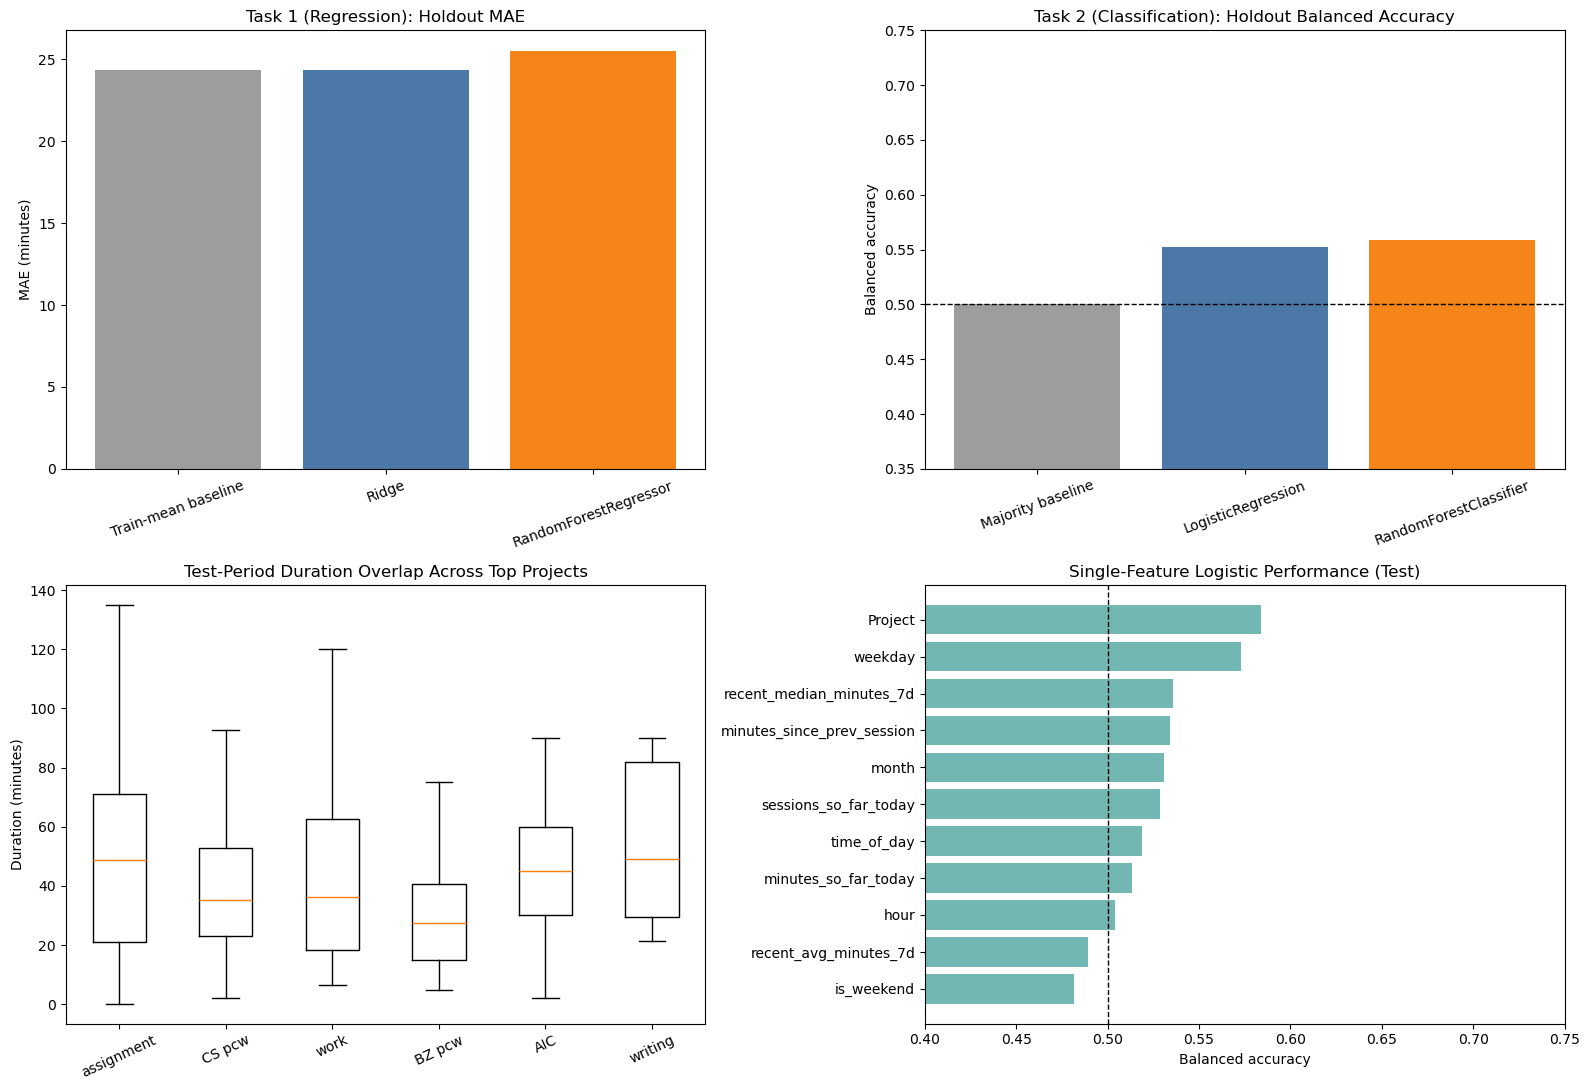

In [ ]:
'''RESULTS VISUALIZATION'''

MEDIAN_MINUTES = 37.69

# Setup diagnostics dataframe (unclipped, chronological)
viz_df = model_df.copy()
viz_df = viz_df.dropna(
    subset=['start_datetime', 'duration_minutes', 'Project', 'weekday', 'time_of_day', 'hour', 'month', 'is_weekend']
).copy()
viz_df = viz_df.sort_values('start_datetime').copy()

viz_df['session_date'] = viz_df['start_datetime'].dt.date
viz_df['minutes_since_prev_session'] = viz_df['start_datetime'].diff().dt.total_seconds() / 60
viz_df['minutes_since_prev_session'] = viz_df['minutes_since_prev_session'].clip(lower=0)
viz_df['sessions_so_far_today'] = viz_df.groupby('session_date').cumcount()
running_today = viz_df.groupby('session_date')['duration_minutes'].cumsum()
viz_df['minutes_so_far_today'] = running_today - viz_df['duration_minutes']
viz_df = viz_df.set_index('start_datetime').sort_index()
viz_df['recent_avg_minutes_7d'] = viz_df['duration_minutes'].shift(1).rolling('7D', min_periods=1).mean()
viz_df['recent_median_minutes_7d'] = viz_df['duration_minutes'].shift(1).rolling('7D', min_periods=1).median()
viz_df = viz_df.reset_index()

feature_cols = [
    'Project', 'weekday', 'time_of_day',
    'hour', 'month', 'is_weekend',
    'minutes_since_prev_session', 'sessions_so_far_today', 'minutes_so_far_today',
    'recent_avg_minutes_7d', 'recent_median_minutes_7d',
]

categorical_features = ['Project', 'weekday', 'time_of_day']
numeric_features = [
    'hour', 'month', 'is_weekend',
    'minutes_since_prev_session', 'sessions_so_far_today', 'minutes_so_far_today',
    'recent_avg_minutes_7d', 'recent_median_minutes_7d',
]

X = viz_df[feature_cols].copy()
y_reg = viz_df['duration_minutes'].astype(float)
y_cls = (viz_df['duration_minutes'] >= MEDIAN_MINUTES).astype(int)

split_idx = int(len(viz_df) * 0.8)
X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
y_reg_train, y_reg_test = y_reg.iloc[:split_idx], y_reg.iloc[split_idx:]
y_cls_train, y_cls_test = y_cls.iloc[:split_idx], y_cls.iloc[split_idx:]


def make_preprocess(cols):
    cat = [c for c in cols if c in categorical_features]
    num = [c for c in cols if c in numeric_features]
    return ColumnTransformer(
        transformers=[
            ('cat', OneHotEncoder(handle_unknown='ignore'), cat),
            ('num', Pipeline([
                ('imputer', SimpleImputer(strategy='median')),
                ('scaler', StandardScaler()),
            ]), num),
        ],
        remainder='drop',
    )

# Regression task comparison
reg_baseline_pred = np.full(len(y_reg_test), y_reg_train.mean())
regression_results = [
    {
        'model': 'Train-mean baseline',
        'MAE': mean_absolute_error(y_reg_test, reg_baseline_pred),
        'RMSE': np.sqrt(mean_squared_error(y_reg_test, reg_baseline_pred)),
        'R2': r2_score(y_reg_test, reg_baseline_pred),
    }
]

for name, model in {
    'Ridge': Ridge(alpha=1.0),
    'RandomForestRegressor': RandomForestRegressor(
        n_estimators=400,
        min_samples_leaf=3,
        random_state=42,
        n_jobs=-1,
    ),
}.items():
    pipe = Pipeline([
        ('preprocess', make_preprocess(feature_cols)),
        ('model', model),
    ])
    pipe.fit(X_train, y_reg_train)
    pred = pipe.predict(X_test)
    regression_results.append(
        {
            'model': name,
            'MAE': mean_absolute_error(y_reg_test, pred),
            'RMSE': np.sqrt(mean_squared_error(y_reg_test, pred)),
            'R2': r2_score(y_reg_test, pred),
        }
    )

regression_df = pd.DataFrame(regression_results)

# Classification task comparison
classification_results = []
classification_models = {
    'Majority baseline': DummyClassifier(strategy='most_frequent'),
    'LogisticRegression': LogisticRegression(max_iter=5000, class_weight='balanced', random_state=42),
    'RandomForestClassifier': RandomForestClassifier(
        n_estimators=400,
        min_samples_leaf=3,
        class_weight='balanced_subsample',
        random_state=42,
        n_jobs=-1,
    ),
}

for name, model in classification_models.items():
    if name == 'Majority baseline':
        model.fit(X_train, y_cls_train)
        pred = model.predict(X_test)
    else:
        pipe = Pipeline([
            ('preprocess', make_preprocess(feature_cols)),
            ('model', model),
        ])
        pipe.fit(X_train, y_cls_train)
        pred = pipe.predict(X_test)

    classification_results.append(
        {
            'model': name,
            'accuracy': accuracy_score(y_cls_test, pred),
            'balanced_accuracy': balanced_accuracy_score(y_cls_test, pred),
        }
    )

classification_df = pd.DataFrame(classification_results)

# Single-feature classification strength (balanced accuracy)
single_feature_rows = []
for feat in feature_cols:
    pipe = Pipeline([
        ('preprocess', make_preprocess([feat])),
        ('model', LogisticRegression(max_iter=5000, class_weight='balanced', random_state=42)),
    ])
    pipe.fit(X_train[[feat]], y_cls_train)
    pred = pipe.predict(X_test[[feat]])
    single_feature_rows.append(
        {
            'feature': feat,
            'balanced_accuracy': balanced_accuracy_score(y_cls_test, pred),
        }
    )

single_feature_df = pd.DataFrame(single_feature_rows).sort_values('balanced_accuracy', ascending=True)

# Overlap check by project (test window only)
test_df = viz_df.iloc[split_idx:].copy()
project_counts = test_df['Project'].value_counts()
top_projects = project_counts.head(6).index.tolist()
box_data = [test_df.loc[test_df['Project'] == p, 'duration_minutes'].values for p in top_projects]

# Print metric tables
print('Regression diagnostics (chronological holdout):')
display(regression_df.sort_values('MAE'))
print('Classification diagnostics (chronological holdout):')
display(classification_df.sort_values('balanced_accuracy', ascending=False))
print('Single-feature classification strength (balanced accuracy):')
display(single_feature_df.sort_values('balanced_accuracy', ascending=False))

# Visual summary
fig, axes = plt.subplots(2, 2, figsize=(16, 11))

# Regression comparison
ax = axes[0, 0]
plot_reg = regression_df.set_index('model').loc[['Train-mean baseline', 'Ridge', 'RandomForestRegressor']]
ax.bar(plot_reg.index, plot_reg['MAE'], color=['#9D9D9D', '#4C78A8', '#F58518'])
ax.set_title('Task 1 (Regression): Holdout MAE')
ax.set_ylabel('MAE (minutes)')
ax.tick_params(axis='x', rotation=20)

# Classification comparison
ax = axes[0, 1]
plot_cls = classification_df.set_index('model').loc[['Majority baseline', 'LogisticRegression', 'RandomForestClassifier']]
ax.bar(plot_cls.index, plot_cls['balanced_accuracy'], color=['#9D9D9D', '#4C78A8', '#F58518'])
ax.axhline(0.5, color='black', linestyle='--', linewidth=1)
ax.set_ylim(0.35, 0.75)
ax.set_title('Task 2 (Classification): Holdout Balanced Accuracy')
ax.set_ylabel('Balanced accuracy')
ax.tick_params(axis='x', rotation=20)

# Duration overlap by project
ax = axes[1, 0]
ax.boxplot(box_data, labels=top_projects, showfliers=False)
ax.set_title('Test-Period Duration Overlap Across Top Projects')
ax.set_ylabel('Duration (minutes)')
ax.tick_params(axis='x', rotation=25)

# Single-feature predictive strength
ax = axes[1, 1]
ax.barh(single_feature_df['feature'], single_feature_df['balanced_accuracy'], color='#72B7B2')
ax.axvline(0.5, color='black', linestyle='--', linewidth=1)
ax.set_xlim(0.40, max(0.75, single_feature_df['balanced_accuracy'].max() + 0.03))
ax.set_title('Single-Feature Logistic Performance (Test)')
ax.set_xlabel('Balanced accuracy')

plt.tight_layout()
plt.show()

